The code to load in Lung dataset and the to use the UNET class is the same as the train ipymb files present in the BCE folders

In [1]:
from pathlib import Path

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from celluloid import Camera
import monai
from monai.networks.nets import UNet
# from dataset import LungDataset
# from model import UNet

In [2]:
class LungDataset(torch.utils.data.Dataset):
    def __init__(self, root, augment_params):
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params
    
    @staticmethod
    def extract_files(root):
        """
        Extract the paths to all slices given the root path (ends with train or val)
        """
        files = []
        for subject in root.glob("*"):   # Iterate over the subjects
            slice_path = subject/"data"  # Get the slices for current subject
            for slice in slice_path.glob("*"):
                files.append(slice)
        return files
    
    
    @staticmethod
    def change_img_to_label_path(path):
        """
        Replace data with mask to get the masks
        """
        parts = list(path.parts)
        parts[parts.index("data")] = "masks"
        return Path(*parts)

    def augment(self, slice, mask):
        """
        Augments slice and segmentation mask in the exact same way
        Note the manual seed initialization
        """
        ###################IMPORTANT###################
        # Fix for https://discuss.pytorch.org/t/dataloader-workers-generate-the-same-random-augmentations/28830/2
        random_seed = torch.randint(0, 1000000, (1,))[0].item()
        imgaug.seed(random_seed)
        #####################################################
        # mask = SegmentationMapsOnImage(mask, mask.shape)
        mask = SegmentationMapsOnImage(mask.astype(np.uint8), mask.shape)
        slice_aug, mask_aug = self.augment_params(image=slice, segmentation_maps=mask)
        mask_aug = mask_aug.get_arr()
        return slice_aug, mask_aug
    
    def __len__(self):
        """
        Return the length of the dataset (length of all files)
        """
        return len(self.all_files)
    
    
    def __getitem__(self, idx):
        """
        Given an index return the (augmented) slice and corresponding mask
        Add another dimension for pytorch
        """
        file_path = self.all_files[idx]
        mask_path = self.change_img_to_label_path(file_path)
        slice = np.load(file_path)
        mask = np.load(mask_path)
        
        if self.augment_params:
            slice, mask = self.augment(slice, mask)
        
        return np.expand_dims(slice, 0), np.expand_dims(mask, 0)

In [3]:
seq = iaa.Sequential([
    iaa.Affine(translate_percent=(0.15), 
               scale=(0.85, 1.15), # zoom in or out
               rotate=(-45, 45)#
               ),  # rotate up to 45 degrees
    iaa.ElasticTransformation()  # Elastic Transformations
                ])


In [4]:
# Create the dataset objects
train_path = Path("/BMIA_Project/final_project_results/BCE/Task06_Lung/Preprocessed/train/")
val_path = Path("/BMIA_Project/final_project_results/BCE/Task06_Lung/Preprocessed/val/")

train_dataset = LungDataset(train_path, seq)
val_dataset = LungDataset(val_path, None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 14484 train images and 1283 val images


In [21]:
import monai
from monai.networks.nets import UNet

class UNetSegmentation(torch.nn.Module):
    def __init__(self, in_channels=1, out_channels=1, num_filters=[64, 128, 256, 512]):
        super(UNetSegmentation, self).__init__()
        self.unet = UNet(
            spatial_dims=2,
            in_channels=in_channels,
            out_channels=out_channels,
            channels=num_filters,
            strides=[2, 2, 2],
            num_res_units=2,
        )

    def forward(self, x):
        return self.unet(x)

# model = UNetSegmentation()
# input_tensor = torch.randn((1, 1, 256, 256))
# output_tensor = model(input_tensor)
# print(random_input)
# print(output)
# print(output.shape)

In [22]:
class TumorSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
          # Initialize the U-Net model for segmentation
        self.model = UNetSegmentation()
        
        # Set up the optimizer and loss function
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss()

    def forward(self, data):
        # Perform a forward pass through the model
        pred = self.model(data)
        return pred

    def training_step(self, batch, batch_idx):
        ct, mask = batch
        mask = mask.float()
        
        # Pass the input data through the model and compute the loss
        pred = self(ct.float())
        loss = self.loss_fn(pred, mask)
        
        # Log the training loss
        self.log("Train Dice", loss)
        
        # Log training images every 50 batches
        if batch_idx % 50 == 0:
            self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), "Train")
            
        return loss

    def validation_step(self, batch, batch_idx):
        ct, mask = batch
        mask = mask.float()

        # Pass the input data through the model and compute the loss
        pred = self(ct.float())
        loss = self.loss_fn(pred, mask)
        
        # Log the validation loss
        self.log("Val Dice", loss)
        
        # Log validation images every 50 batches
        if batch_idx % 50 == 0:
            self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), "Val")
        
        return loss

    def log_images(self, ct, pred, mask, name):
        
        results = []
        
        # Threshold the predictions at 0.5
        pred = pred > 0.5
        
        # Create a plot to visualize the ground truth and predicted masks
        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(ct[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0]==0, mask[0][0])
        axis[0].imshow(mask_, alpha=0.6)
        axis[0].set_title("Ground Truth")
        
        axis[1].imshow(ct[0][0], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][0]==0, pred[0][0])
        axis[1].imshow(mask_, alpha=0.6, cmap="autumn")
        axis[1].set_title("Pred")

        # Log the figure to the experiment logger
        self.logger.experiment.add_figure(f"{name} Prediction vs Label", fig, self.global_step)

    def configure_optimizers(self):
        # Always return a list of optimizers (even if there's only one)
        return [self.optimizer]

In [12]:
class DiceScore(torch.nn.Module):
    """
    class to compute the Dice Loss
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
                
        #flatten label and prediction tensors
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        
        counter = (pred * mask).sum()  # Counter       
        denum = pred.sum() + mask.sum()  # denominator
        dice = (2*counter)/denum
        
        return dice


In [24]:
model = TumorSegmentation.load_from_checkpoint("/BMIA_Project/final_project_results/best_model/monai_model/logs_model2/logs/lightning_logs/version_0/checkpoints/epoch=26-step=48897.ckpt")
model.eval();
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device);

In [25]:
preds = []
labels = []

for slice, label in tqdm(val_dataset):
    slice = torch.tensor(slice).float().to(device).unsqueeze(0)
    with torch.no_grad():
        pred = torch.sigmoid(model(slice))
    preds.append(pred.cpu().numpy())
    labels.append(label)
    
preds = np.array(preds)
labels = np.array(labels)

  0%|          | 0/1283 [00:00<?, ?it/s]

In [26]:
dice_score = DiceScore()(torch.from_numpy(preds), torch.from_numpy(labels).unsqueeze(0).float())
print(f"The Val Dice Score is: {dice_score}")

The Val Dice Score is: 0.19399157166481018


Performing testing on one of the samples

In [27]:
THRESHOLD = 0.5

In [28]:
import nibabel as nib
import cv2

In [29]:
subject = Path("/BMIA_Project/final_project_results/BCE/Task06_Lung/imagesTs/lung_017.nii.gz")
ct = nib.load(subject).get_fdata() / 3071  # standardize
ct = ct[:,:,30:]  # crop

In [30]:
segmentation = []
label = []
scan = []

for i in range(ct.shape[-1]):
    slice = ct[:,:,i]
    slice = cv2.resize(slice, (256, 256))
    slice = torch.tensor(slice)
    scan.append(slice)
    slice = slice.unsqueeze(0).unsqueeze(0).float().to(device)
    
    with torch.no_grad():
        pred = model(slice)[0][0].cpu()
    pred = pred > THRESHOLD
    segmentation.append(pred)
    label.append(segmentation)
    

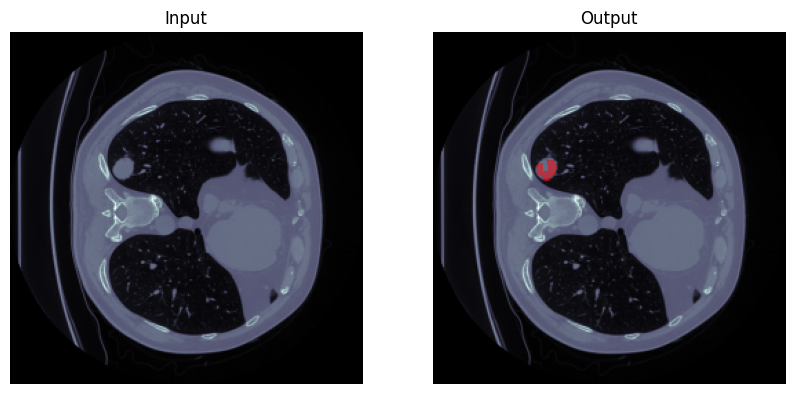

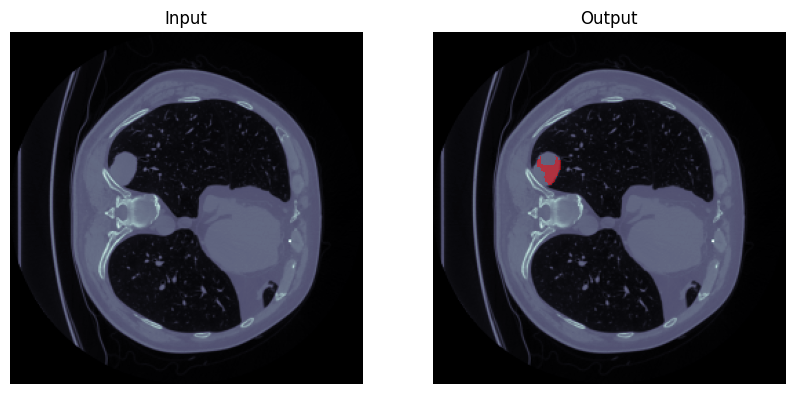

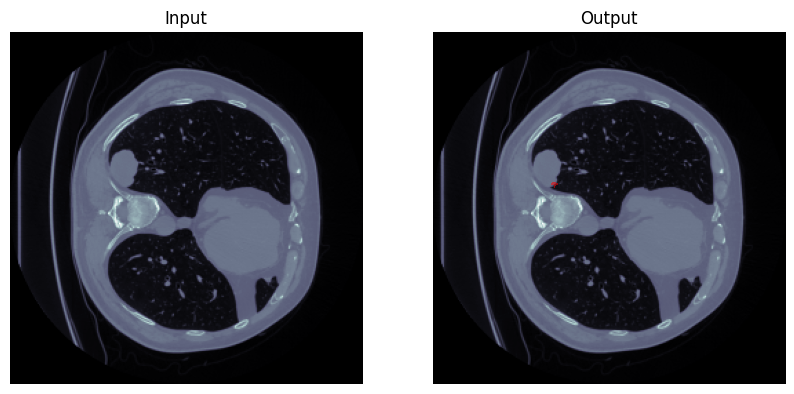

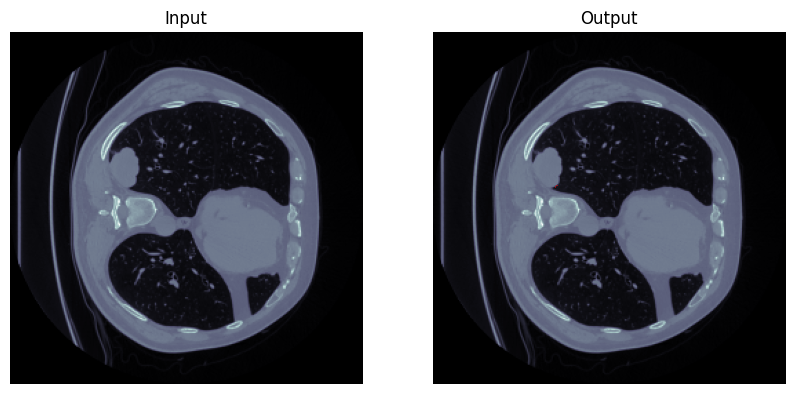

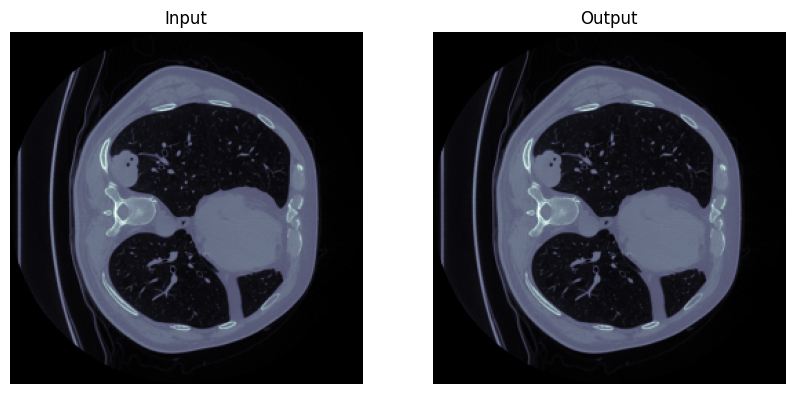

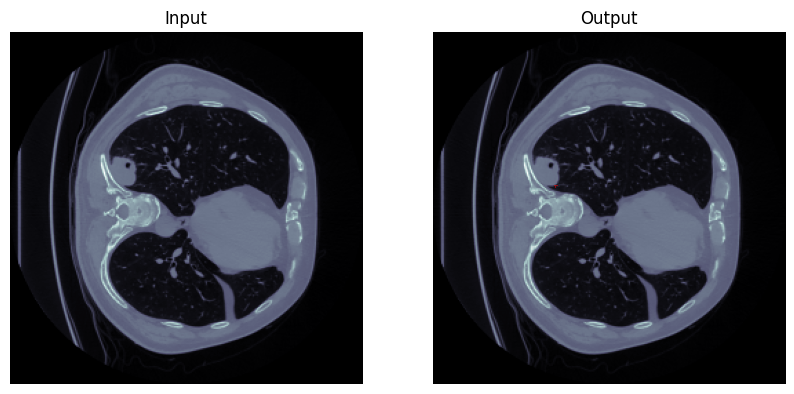

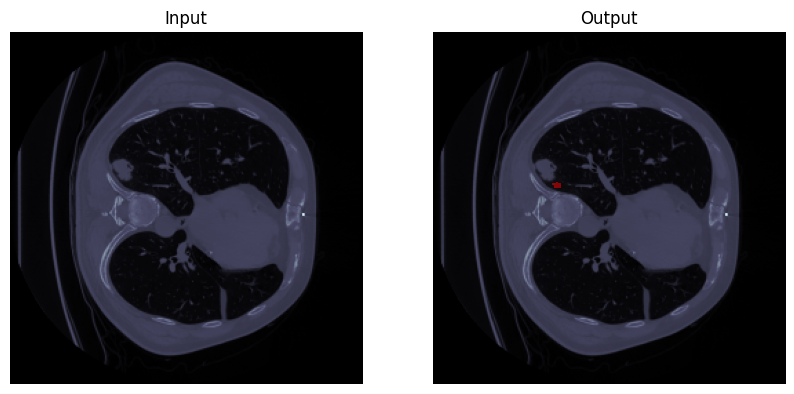

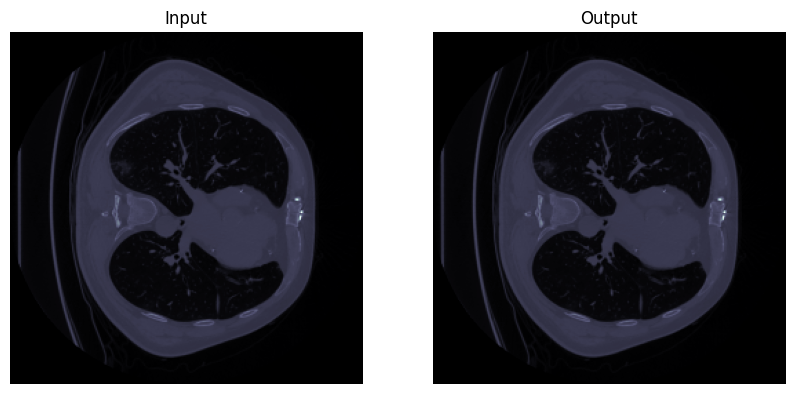

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def display_slice(scan, segmentation, index):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Sagittal view. Skipping every second slice is no longer necessary since we're not creating an animation.
    axes[0].imshow(scan[index], cmap="bone")
    axes[0].set_title("Input")
    axes[0].axis("off")
    
    axes[1].imshow(scan[index], cmap="bone")
    mask = np.ma.masked_where(segmentation[index] == 0, segmentation[index])
    axes[1].imshow(mask, alpha=0.5, cmap="autumn")  # Use autumn colormap to get red segmentation
    axes[1].set_title("Output")
    axes[1].axis("off")
    
    plt.show()

# Example usage
for i in range(200,280, 10):
    display_slice(scan, segmentation, i)

# Convert to video if required

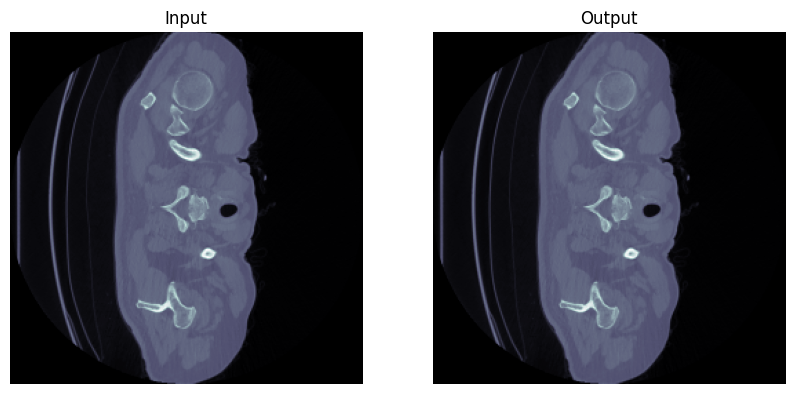

In [45]:
from celluloid import Camera

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
camera = Camera(fig)  # create the camera object from celluloid

for i in range(0, len(scan), 2):  # Sagital view. Skip every second slice to reduce the video length
    axes[0].imshow(scan[i], cmap="bone")
    axes[0].set_title("Input")
    axes[0].axis("off")
    
    axes[1].imshow(scan[i], cmap="bone")
    mask = np.ma.masked_where(segmentation[i] == 0, segmentation[i])
    axes[1].imshow(mask, alpha=0.5, cmap="autumn")  # Use autumn colormap to get red segmentation
    axes[1].set_title("Output")
    axes[1].axis("off")
    
    camera.snap()  # Store the current slice

animation = camera.animate()  # create the animation

In [46]:
from IPython.display import HTML
HTML(animation.to_html5_video())  # convert the animation to a video


2023-04-22 19:40:54,294 - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2023-04-22 19:40:54,295 - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1000x500 -pix_fmt rgba -r 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y 'C:\Users\Vaishak\AppData\Local\Temp\tmp0t6f5lnr\temp.m4v'


C:\Users\Vaishak\anaconda3\envs\ailab3\lib\site-packages\matplotlib\image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\Vaishak\anaconda3\envs\ailab3\lib\site-packages\matplotlib\image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2
